In [23]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.classes.function import path_weight
from tqdm import tqdm

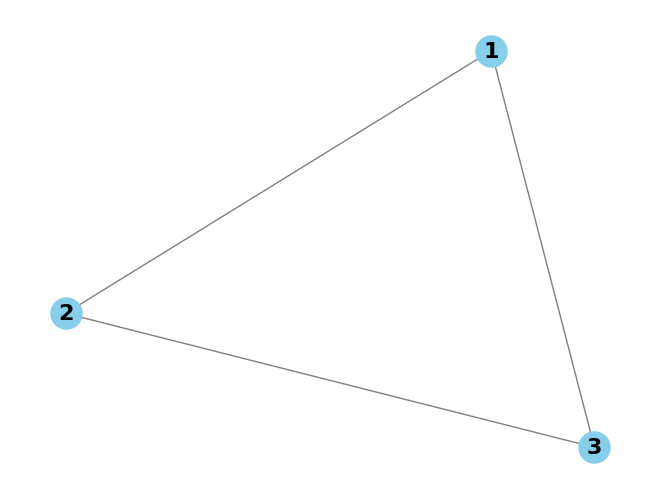

In [3]:
#  Exemplo de grafo simples

# Criação do grafo
G = nx.Graph()

# Adiciona nós
G.add_node(1)
G.add_node(2)
G.add_node(3)

# Adiciona arestas entre os nós
G.add_edge(1, 2)
G.add_edge(1, 3)
G.add_edge(2, 3)

# Desenho do grafo
nx.draw(G, with_labels=True, node_color="skyblue", node_size=500, font_size=16, font_weight="bold", edge_color="gray")
plt.show()


In [4]:
#  função criada pelo timber


def create_graph(transports):
    graph = {}

    # Creating the graph with the list of transports
    for i,transport in tqdm(transports.iterrows()):
        id_emp_orig = transport['node_src']
        id_emp_dest = transport['node_dest']

        volume = transport['vol']

        # Graph is a dict (source) -> (destination, weight)
        if graph.get(id_emp_orig) is None:
            # if source is not in the graph we need to map it as source to the destination
            graph[id_emp_orig] = {id_emp_dest: {'weight': volume }}
        else:
            # if source is already in the graph
            # 1. new destination from that source: create the edge
            # 2. source already mapped to destination: increase the volume in that edge
            if graph[id_emp_orig].get(id_emp_dest) is None:
                graph[id_emp_orig][id_emp_dest] = {'weight': volume }
            else:
                graph[id_emp_orig][id_emp_dest]['weight'] += volume

    # In this context we want to maximize paths over the volume
    # Since most functions minimizes over the weight of the edges,
    # we need to invert the relation
    for source, targets in graph.items():
        for target, volume in targets.items():
            graph[source][target]['weight'] = -1 * volume['weight']

    return nx.DiGraph(graph)

In [5]:
transportes_junho = pd.read_csv('./df_06.csv')

C:\Users\jaime\AppData\Local\Temp\ipykernel_16496\2878475265.py:1: DtypeWarning: Columns (4,18) have mixed types. Specify dtype option on import or set low_memory=False.
  transportes_junho = pd.read_csv('./df_06.csv')


In [6]:
transportes_junho.head()

,Unnamed: 0.1,index,Unnamed: 0,Codigo,Registro,TpRegistro,OrigemID,NomeOrigem,CPF_CNPJ_Rem,CTFOrigem,...,NomePopular,NomeCientifico,Unidade,Volume,DtEmissao,Ano,Status,NomePopularAgregado,datetimeDtEmissao,ID
0,66,260,260,3415558397763288,17490451,DOF,PTO-72559586000130,PRAIANA MATERIAIS DE CONSTRUÇAO LTDA,72559586000130,1586031,...,Cambarárosa,Qualeaparaensis,M3,0.2925,06/03/2017,2017,Emitido,Mandioqueiro,2017-06-03,66
1,82,330,330,2649555542995653,17999737,DOF,PTO-75274423002738,COMERCIAL IVAIPORÃ LTDA,75274423002738,5391410,...,Cambarápreto,Qualeaalbiflora,M3,0.0182,26/06/2017,2017,Emitido,Mandioqueiro,2017-06-26,82
2,97,380,380,7498553285396353,17947129,DOF,PTO-01079926000187,MATELLI MATERIAIS DE CONSTRUÇÃO LTDA - ME,1079926000187,29249,...,Cambarápreto,Qualeaalbiflora,M3,0.0187,14/06/2017,2017,Emitido,Mandioqueiro,2017-06-14,97
3,98,382,382,4697439386861433,17983686,DOF,PTO-77172161000197,DEPOSITO DE MATERIAIS PARA CONSTRUÇÃO NICHELE ...,77172161000197,47699,...,Cambará,Qualeaspp,M3,0.3750,22/06/2017,2017,Emitido,Mandioqueiro,2017-06-22,98
4,101,400,400,4699187417844317,17951368,DOF,PTO-85491520000105,MATERIAIS DE CONST.STA CLAUDIA LTDA,85491520000105,1285661,...,Cambarápreto,Qualeaalbiflora,M3,0.2330,14/06/2017,2017,Emitido,Mandioqueiro,2017-06-14,101


In [7]:
transportes_junho['TpDes'].value_counts()

TpDes
FINAL        18157
PTO_IBAMA     8381
Name: count, dtype: int64

In [8]:
transportes_junho['TpRem'].value_counts()

TpRem
PTO_IBAMA    26072
MANEJO         466
Name: count, dtype: int64

In [9]:
contagem_tipos_rem = transportes_junho.groupby('CPF_CNPJ_Rem').size()
contagem_tipos_rem

CPF_CNPJ_Rem
657233170         1
2546223216        1
2616690950        9
2737218870        2
3385469953        5
                 ..
96707302000173    1
97138077000164    1
97297477000112    1
97520331000275    1
97520331000356    1
Length: 2121, dtype: int64

In [10]:
contagem_tipos_rem_id = transportes_junho.groupby('OrigemID').size()
contagem_tipos_rem_id 

OrigemID
MANEJO-00657233170(-12.922,-61.459)      1
MANEJO-01801325000136(-9.577,-65.888)    1
MANEJO-02546223216(-9.459,-66.024)       1
MANEJO-02616690950(-9.678,-64.828)       9
MANEJO-02737218870(-8.626,-63.125)       2
                                        ..
PTO-96707302000173                       1
PTO-97138077000164                       1
PTO-97297477000112                       1
PTO-97520331000275                       1
PTO-97520331000356                       1
Length: 2178, dtype: int64

In [11]:
contagem_tipos_des = transportes_junho.groupby('CPF_CNPJ_Des').size()
contagem_tipos_des 

CPF_CNPJ_Des
17285470       1
22619100       3
40582086       1
60389133       1
64602834       1
              ..
99934825449    1
99935520897    1
99948400372    2
99957418815    1
9998099897     1
Length: 15277, dtype: int64

In [12]:
contagem_tipos_des_id = transportes_junho.groupby('DestinoID').size()
contagem_tipos_des_id

DestinoID
FINAL-00015915840    1
FINAL-00016478908    2
FINAL-00017285470    1
FINAL-00022434909    1
FINAL-00022619100    3
                    ..
PTO-98834126904      1
PTO-99146746820      3
PTO-99453606804      1
PTO-99588439868      1
PTO-99848406891      1
Length: 15018, dtype: int64

Temos mais IDs de origem do que CNPJs de origem.
Já no caso dos CPF/CNPj dos destinatários, temos o mesmo número. 

In [13]:
#  Separando os nós pelo cnpj
transportes_junho.columns

Index(['Unnamed: 0.1', 'index', 'Unnamed: 0', 'Codigo', 'Registro',
       'TpRegistro', 'OrigemID', 'NomeOrigem', 'CPF_CNPJ_Rem', 'CTFOrigem',
       'EntJuridica_Rem', 'TpRem', 'UFOrigem', 'MunOrigem', 'LatOrigem',
       'LongOrigem', 'DestinoID', 'NomeDestino', 'CPF_CNPJ_Des', 'CTFDestino',
       'EntJuridica_Des', 'TpDes', 'UFDestino', 'MunDestino', 'LatDestino',
       'LongDestino', 'Autorizacao', 'TpAutorizacao', 'Produto', 'NomePopular',
       'NomeCientifico', 'Unidade', 'Volume', 'DtEmissao', 'Ano', 'Status',
       'NomePopularAgregado', 'datetimeDtEmissao', 'ID'],
      dtype='object')

In [14]:
transportes_junho['TpRem']

0        PTO_IBAMA
1        PTO_IBAMA
2        PTO_IBAMA
3        PTO_IBAMA
4        PTO_IBAMA
           ...    
26533    PTO_IBAMA
26534    PTO_IBAMA
26535    PTO_IBAMA
26536    PTO_IBAMA
26537    PTO_IBAMA
Name: TpRem, Length: 26538, dtype: object

In [15]:
transportes_junho[['CPF_CNPJ_Rem', 'CPF_CNPJ_Des','TpRem', 'TpDes' ]]

,CPF_CNPJ_Rem,CPF_CNPJ_Des,TpRem,TpDes
0,72559586000130,38919389934,PTO_IBAMA,FINAL
1,75274423002738,07865912935,PTO_IBAMA,FINAL
2,1079926000187,88689433015,PTO_IBAMA,FINAL
3,77172161000197,25389947991,PTO_IBAMA,FINAL
4,85491520000105,50389521949,PTO_IBAMA,FINAL
...,...,...,...,...
26533,88817622000158,414002083,PTO_IBAMA,FINAL
26534,613799000191,706719077,PTO_IBAMA,FINAL
26535,94543717000123,29203201068,PTO_IBAMA,FINAL
26536,89614101000166,50714082015,PTO_IBAMA,FINAL


Criando Nós

In [16]:
rem_df = transportes_junho[['CPF_CNPJ_Rem', 'TpRem']].rename(columns={'CPF_CNPJ_Rem': 'CNPJ_CPF', 'TpRem': 'type'})
rem_df['source'] = 'Remetente'

# Criar DataFrame para CPF_CNPJ_Des e TpDes
des_df = transportes_junho[['CPF_CNPJ_Des', 'TpDes']].rename(columns={'CPF_CNPJ_Des': 'CNPJ_CPF', 'TpDes': 'type'})
des_df['source'] = 'Destinatário'

# Concatenar ambos os DataFrames
node_df= pd.concat([rem_df, des_df], ignore_index=True)
node_df

,CNPJ_CPF,type,source
0,72559586000130,PTO_IBAMA,Remetente
1,75274423002738,PTO_IBAMA,Remetente
2,1079926000187,PTO_IBAMA,Remetente
3,77172161000197,PTO_IBAMA,Remetente
4,85491520000105,PTO_IBAMA,Remetente
...,...,...,...
53071,414002083,FINAL,Destinatário
53072,706719077,FINAL,Destinatário
53073,29203201068,FINAL,Destinatário
53074,50714082015,FINAL,Destinatário


In [17]:
node_df['type'].value_counts()

type
PTO_IBAMA    34453
FINAL        18157
MANEJO         466
Name: count, dtype: int64

Criando o dataframe com as arestas

In [18]:
volumes_transporte_junho = transportes_junho['Volume']*1000
volumes_transporte_junho

0        292.5
1         18.2
2         18.7
3        375.0
4        233.0
         ...  
26533    100.0
26534    584.2
26535    488.0
26536     67.5
26537    632.0
Name: Volume, Length: 26538, dtype: float64

In [19]:
volume_minimo_junho = transportes_junho['Volume'].min()
volume_maximo_junho =transportes_junho['Volume'].max()

print(f"Volume Mínimo registrado em Junho: {volume_minimo_junho}")
print(f"Volume Máximo registrado em Junho: {volume_maximo_junho}")

Volume Mínimo registrado em Junho: 0.0001
Volume Máximo registrado em Junho: 73.3894


In [20]:
arestas = transportes_junho[['CPF_CNPJ_Rem', 'CPF_CNPJ_Des', 'Volume']].rename(columns={'CPF_CNPJ_Rem': 'node_src', 'CPF_CNPJ_Des': 'node_des', 'Volume': 'vol'})

In [21]:
arestas

,node_src,node_des,vol
0,72559586000130,38919389934,0.2925
1,75274423002738,07865912935,0.0182
2,1079926000187,88689433015,0.0187
3,77172161000197,25389947991,0.3750
4,85491520000105,50389521949,0.2330
...,...,...,...
26533,88817622000158,414002083,0.1000
26534,613799000191,706719077,0.5842
26535,94543717000123,29203201068,0.4880
26536,89614101000166,50714082015,0.0675


In [22]:
graph = create_graph(arestas)

NameError: name 'tqdm' is not defined